<a href="https://colab.research.google.com/github/benchov/AlgoTrading/blob/master/HMM_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyhhmm
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyhhmm: filename=pyhhmm-2.0.1-py3-none-any.whl size=35505 sha256=9a160843c2dc4bc84092c003ce17086d86d58f12e0525dbdca38c288cca7e98f
  Stored in directory: /root/.cache/pip/wheels/f5/06/8b/f56001a4de0010706182f4db98d045779a517011d47476708e
Successfully built pyhhmm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

In [3]:
start_date = '2017-01-01'
end_date = '2022-06-01'
symbol = 'SPY'
data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
data = data[['Open', 'High', 'Low', 'Adj Close']]
data.head()

,Open,High,Low,Adj Close
Date,,,,
2017-01-03,225.039993,225.830002,223.880005,203.788055
2017-01-04,225.619995,226.750000,225.610001,205.000443
2017-01-05,226.270004,226.580002,225.479996,204.837555
2017-01-06,226.529999,227.750000,225.899994,205.570374
2017-01-09,226.910004,227.070007,226.419998,204.891830


In [4]:
df = data.copy()
df['Returns'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace=True) 
df.head()

,Open,High,Low,Adj Close,Returns,Range
Date,,,,,,
2017-01-04,225.619995,226.750000,225.610001,205.000443,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,204.837555,-0.000795,0.004879
2017-01-06,226.529999,227.750000,225.899994,205.570374,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,204.891830,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,204.891830,0.000000,0.006371


In [5]:
# add moving avarage
df['ma_12'] = df['Adj Close'].rolling(window=12).mean()
df['ma_21'] = df['Adj Close'].rolling(window=21).mean()

In [6]:
# create train and test dataset
X_train = df[['Returns', 'Range']].iloc[:500]
X_test = df[['Returns', 'Range']].iloc[500:]
df_save = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  862
X_train From:  2017-01-04 00:00:00
X_train To:  2018-12-28 00:00:00
X_test From:  2018-12-31 00:00:00
X_test To:  2022-06-01 00:00:00


In [7]:
# create model
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)

# train model
model.train([np.array(X_train.values)])

# test model prediction capability on train dataset
model.predict([X_train.values])[0][:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [8]:
df_main = df_save.copy()

hmm_result = model.predict([np.array(X_test.values)])
df_main['HMM'] = hmm_result[0]
df_main.head()

,Open,High,Low,Adj Close,Returns,Range,ma_12,ma_21,HMM
Date,,,,,,,,,
2018-12-31,249.559998,250.190002,247.470001,234.892090,0.008759,0.010991,234.400191,241.900970,0
2019-01-02,245.979996,251.210007,245.949997,235.136429,0.001040,0.021387,233.331145,240.906977,3
2019-01-03,248.229996,248.570007,243.669998,229.525421,-0.023863,0.020109,232.176066,239.571480,2
2019-01-04,247.589996,253.110001,247.169998,237.213577,0.033496,0.024032,232.059568,238.439680,1
2019-01-07,252.690002,255.949997,251.690002,239.083908,0.007885,0.016926,232.120733,237.799628,0


In [9]:
# add Moving Avarage Signals to the dataset
df_main.loc[df['ma_12'] > df['ma_21'], 'ma_signal'] = 1
df_main.loc[df['ma_12'] <= df['ma_21'], 'ma_signal'] = 0

In [10]:
# create HMM signal and add to dataset
signal_states = [0,1]
hmm_states = df_main['HMM'].values
hmm_signals = [1 if x in signal_states else 0 for x in hmm_states]
df_main['hmm_signal'] = hmm_signals
df_main.head()

,Open,High,Low,Adj Close,Returns,Range,ma_12,ma_21,HMM,ma_signal,hmm_signal
Date,,,,,,,,,,,
2018-12-31,249.559998,250.190002,247.470001,234.892090,0.008759,0.010991,234.400191,241.900970,0,0.0,1
2019-01-02,245.979996,251.210007,245.949997,235.136429,0.001040,0.021387,233.331145,240.906977,3,0.0,0
2019-01-03,248.229996,248.570007,243.669998,229.525421,-0.023863,0.020109,232.176066,239.571480,2,0.0,0
2019-01-04,247.589996,253.110001,247.169998,237.213577,0.033496,0.024032,232.059568,238.439680,1,0.0,1
2019-01-07,252.690002,255.949997,251.690002,239.083908,0.007885,0.016926,232.120733,237.799628,0,0.0,1


In [12]:
# creating combined signal from Ma and HMM
df_main['main_signal'] = 0

df_main.loc[(df_main['ma_signal'] == 1) & (df_main['hmm_signal'] == 1), 'main_signal'] = 1
# df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1

df_main['main_signal'] = df_main['main_signal'].shift(1)
# df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)
df_main[:100]

,Open,High,Low,Adj Close,Returns,Range,ma_12,ma_21,HMM,ma_signal,hmm_signal,main_signal
Date,,,,,,,,,,,,
2018-12-31,249.559998,250.190002,247.470001,234.892090,0.008759,0.010991,234.400191,241.900970,0,0.0,1,NaN
2019-01-02,245.979996,251.210007,245.949997,235.136429,0.001040,0.021387,233.331145,240.906977,3,0.0,0,0.0
2019-01-03,248.229996,248.570007,243.669998,229.525421,-0.023863,0.020109,232.176066,239.571480,2,0.0,0,0.0
2019-01-04,247.589996,253.110001,247.169998,237.213577,0.033496,0.024032,232.059568,238.439680,1,0.0,1,0.0
2019-01-07,252.690002,255.949997,251.690002,239.083908,0.007885,0.016926,232.120733,237.799628,0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-17,285.140015,288.600006,285.119995,269.835571,-0.006465,0.012205,271.489871,273.388121,0,0.0,1,0.0
2019-05-20,284.059998,285.959991,283.119995,268.051392,-0.006612,0.010031,270.921115,273.115261,0,0.0,1,0.0
2019-05-21,285.829987,286.929993,285.549988,270.468018,0.009016,0.004833,270.329539,272.946238,0,0.0,1,0.0


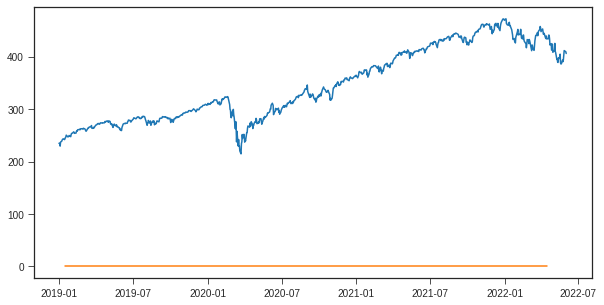

In [16]:
fig = plt.figure(figsize=(10,5))
plt.plot(df_main['Adj Close'])
plt.plot(df_main['main_signal'].loc[df_main['main_signal'] > 0])